<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter2/2_5_TFP%E3%81%AE%E6%A6%82%E8%A6%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlowの使い方

In [1]:
#@title install packages
!pip install watermark

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
cmap = plt.get_cmap("tab10")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

tf.random.set_seed(42)
np.random.seed(42)

### Tensor


In [3]:
# Tensorの生成（constantとconvert_to_tensorはほぼ同じ処理）
t = tf.constant([1., 2., 3.], dtype=tf.float32)
t = tf.convert_to_tensor([1., 2., 3.], dtype=tf.float32)
print(t)

try:
  t[1] = 4.
except TypeError:
  print("Tensorはイミュータブル（変更不可）")

tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)
Tensorはイミュータブル（変更不可）


In [4]:
print(tf.ones([3, 2])) # 全ての要素が1
# print(tf.constant([1, 2, 3])) # Pythonのリストから作成
print()
print(tf.fill([2, 3], 9)) # shapeを指定して、スカラー値で埋める

tf.Tensor(
[[1. 1.]
 [1. 1.]
 [1. 1.]], shape=(3, 2), dtype=float32)

tf.Tensor(
[[9 9 9]
 [9 9 9]], shape=(2, 3), dtype=int32)


In [5]:
t = tf.add([2], [3])
print(t)

t2 = tf.constant([2]) + tf.constant([3])
print(t2)

tf.Tensor([5], shape=(1,), dtype=int32)
tf.Tensor([5], shape=(1,), dtype=int32)


In [6]:
t = tf.ones(3)
print(t.shape)
print(t[tf.newaxis].shape) # 先頭のaxisを追加
print(t[None].shape) # Noneを使うこともできる
print(t[:, tf.newaxis].shape) # 2番目のaxisを追加

t2 = tf.ones((3,2))
print(t2[:, :, tf.newaxis].shape) # 3番目のaxisを追加
print(t2[..., tf.newaxis].shape) # "..."はPythonのEllipsisオブジェクト（省略記号）であり、この場合任意の数の次元を示す。次元数が不明の場合に便利。

(3,)
(1, 3)
(1, 3)
(3, 1)
(3, 2, 1)
(3, 2, 1)


### Variable

In [7]:
v = tf.Variable(1.)
print(v)

v.assign(2.)
print(v)

v.assign_add(3.)
print(v)
# v.read_value()

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>


## 計算グラフ


In [8]:
def original_function(x, y):
  return tf.nn.relu(tf.matmul(x, y))

# デコレータは関数をラップする関数
function1 = tf.function(original_function)

# こちらの記述方法が一般的
@tf.function
def function2(x, y):
  return tf.nn.relu(tf.matmul(x, y))


print(original_function)
print(function1)
print(function2)

<function original_function at 0x7fe7ba07ad40>


In [9]:
import timeit

class SimpleModel(tf.keras.Model):
    """実験用のシンプルなモデル"""
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.lstm = tf.keras.layers.LSTM(10)
        self.dense = tf.keras.layers.Dense(32)

    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dense(x)
        return x

inputs = tf.random.normal([100, 20, 5])

# 計算グラフを利用しない場合
eager_model = SimpleModel()

# 計算グラフを利用する場合
graph_model = tf.function(SimpleModel())

print("Eager time: {:.2f} sec".format(
    timeit.timeit(lambda: eager_model(inputs), number=1000)))
print("Graph time: {:.2f} sec".format(
    timeit.timeit(lambda: graph_model(inputs), number=1000)))

Eager time: 10.50 sec
Graph time: 3.95 sec


In [10]:
@tf.function
def fizzbuzz(n):
  for i in tf.range(n):
    if i % 3 == 0:
      tf.print('Fizz')
    elif i % 5 == 0:
      tf.print('Buzz')
    else:
      tf.print(i)

fizzbuzz(tf.constant(10))

Fizz
1
2
Fizz
4
Buzz
Fizz
7
8
Fizz


In [11]:
print(tf.autograph.to_code(fizzbuzz.python_function))

def tf__fizzbuzz(n):
    with ag__.FunctionScope('fizzbuzz', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:

        def get_state_2():
            return ()

        def set_state_2(block_vars):
            pass

        def loop_body(itr):
            i = itr

            def get_state_1():
                return ()

            def set_state_1(block_vars):
                pass

            def if_body_1():
                ag__.converted_call(ag__.ld(tf).print, ('Fizz',), None, fscope)

            def else_body_1():

                def get_state():
                    return ()

                def set_state(block_vars):
                    pass

                def if_body():
                    ag__.converted_call(ag__.ld(tf).print, ('Buzz',), None, fscope)

                def else_body():
                    ag__.converted_call(ag__.ld(tf).print, (ag__.ld(i),), None, fscope)
              

## 自動微分

In [12]:
def func(x, y):
    return x**2 / 4 + y**2


x = tf.Variable([1.0])
y = tf.Variable([2.0])
with tf.GradientTape() as t:
    # 追跡対象とするTensorを指定。この場合、x, yはVariableなので自動的にwatchされるため、本来は不要。
    t.watch([x, y]) 
    z = func(x, y)

# 勾配の算出  
t.gradient(z, [x, y])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


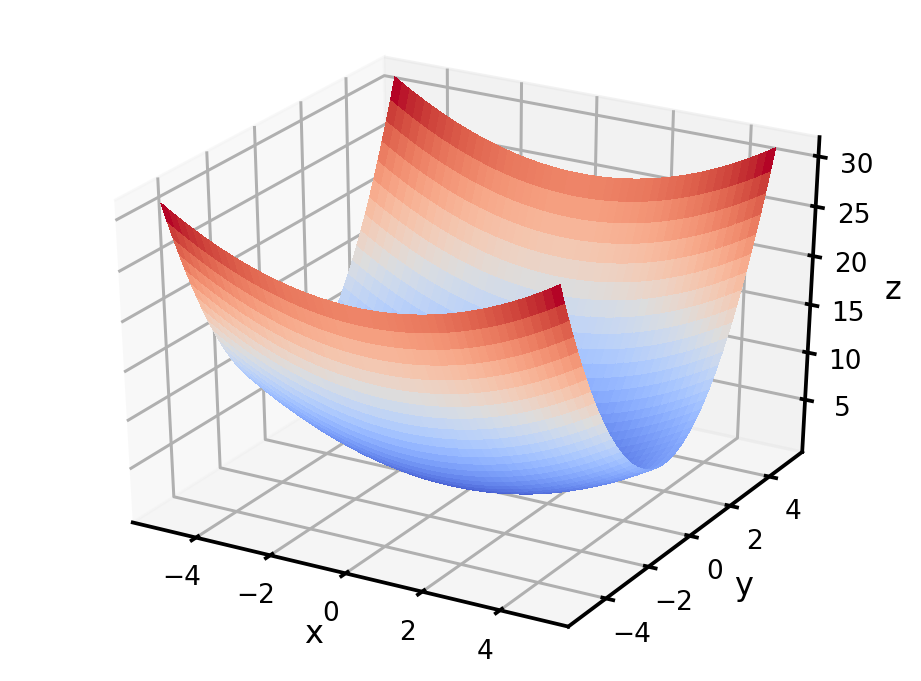

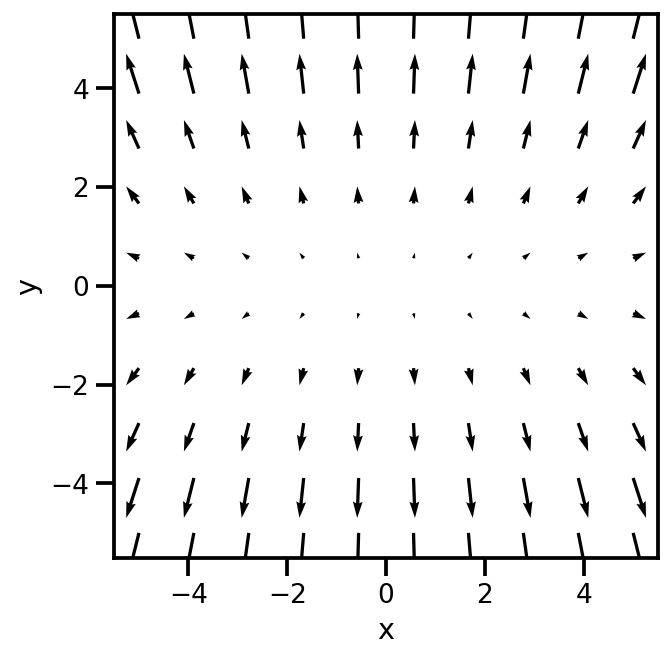

In [13]:
# 目的関数を３次元で可視化
from matplotlib import cm
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

x_coord = y_coord = np.linspace(-5, 5)
XX, YY = np.meshgrid(x_coord, y_coord)
ZZ = func(XX, YY)

# surface plotで3次元のデータを可視化
surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("y", fontsize=16)
ax.set_zlabel("z", fontsize=16)


# 勾配をベクトルとして可視化
x_coord = y_coord = np.linspace(-5, 5, 10)
XX, YY = np.meshgrid(x_coord, y_coord)

x = tf.Variable(XX)
y = tf.Variable(YY)
with tf.GradientTape() as t:
    z = func(x, y)

# 勾配の算出   
x_grads, y_grads = t.gradient(z, [x, y])

fig = plt.figure(figsize=(5, 5))
# matplotli.pyplot.quiverでは矢印によりベクトルを可視化できる
plt.quiver(XX, YY, x_grads, y_grads)
plt.xlabel('x')
plt.ylabel('y')
plt.axes().set_aspect('equal')

## Optimizer

In [14]:
# 初期値
x = tf.Variable([3.0])
y = tf.Variable([4.0])

# lossは引数がなく、最小化したい値を返すcallable
loss = lambda: x**2 / 4 + y**2

epoch = 100
lr = 0.1
losses = []
locs = []

opt = tf.keras.optimizers.SGD(learning_rate=lr)
for _ in range(epoch):
    # minimizeではlossの勾配を計算し、variableを更新する
    opt.minimize(loss, var_list=[x, y])
    losses.append(loss().numpy()[0])
    locs.append([x.numpy()[0], y.numpy()[0]])

print(f'optimized x: {x.numpy()[0]:.2e}')
print(f'optimized y: {y.numpy()[0]:.2e}')

optimized x: 1.78e-02
optimized y: 8.15e-10


Text(0, 0.5, 'z')

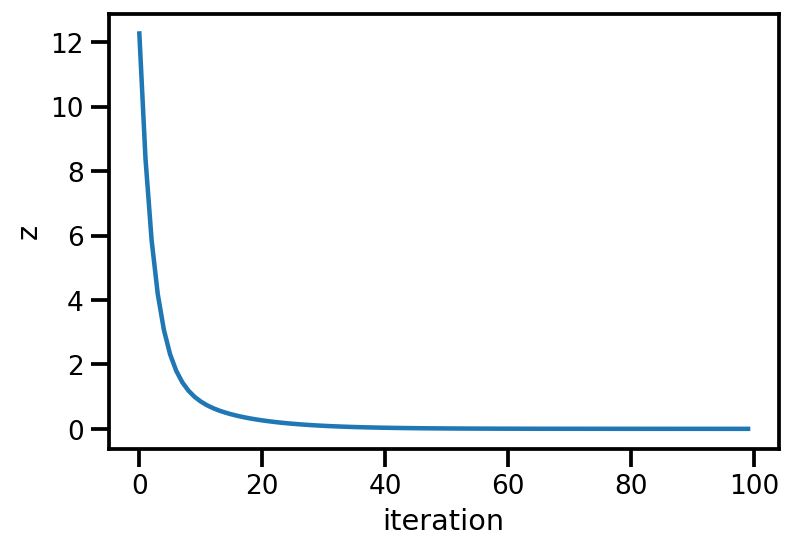

In [15]:
#@title plot z
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('z')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


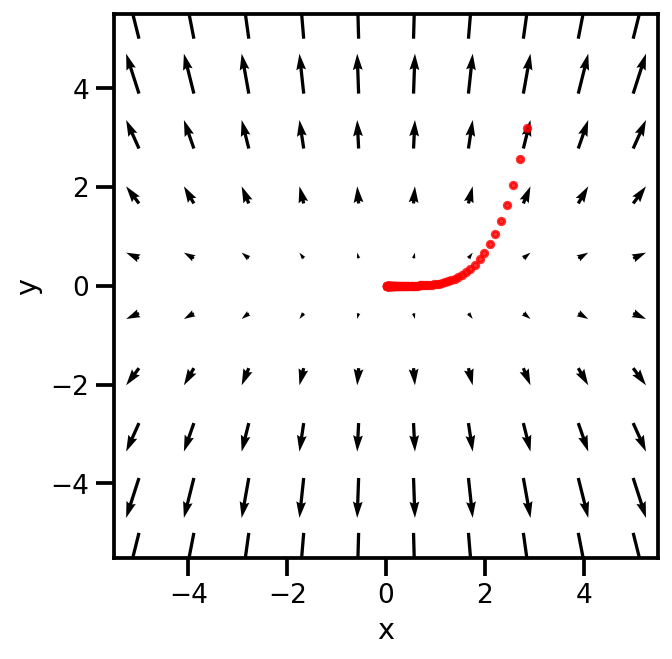

In [16]:
#@title plot x and y
x_coord = y_coord = np.linspace(-5, 5, 10)
XX, YY = np.meshgrid(x_coord, y_coord)
plt.figure(figsize=(5, 5))
plt.quiver(XX, YY, x_grads, y_grads)

locs = np.array(locs)
plt.scatter(locs[:, 0], locs[:, 1], c='r', alpha=0.8, s=10)
plt.xlabel('x')
plt.ylabel('y')

plt.axes().set_aspect('equal')

Text(0.5, 0, 'z')

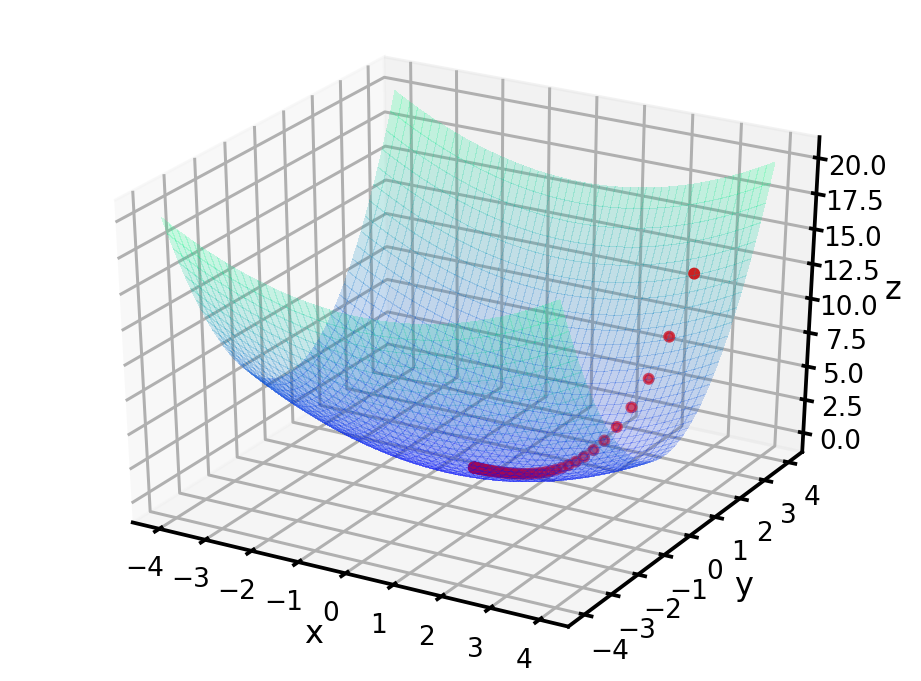

In [17]:
#@title 3次元で可視化
from matplotlib import cm
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

x_coord = y_coord = np.linspace(-4, 4)
XX, YY = np.meshgrid(x_coord, y_coord)
ZZ = func(XX, YY)

surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.winter, alpha=0.2,
                       linewidth=0, antialiased=False)

locs = np.array(locs)
ax.scatter(locs[:, 0], locs[:, 1], func(locs[:, 0], locs[:, 1]), c='r', s=20)

ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("y", fontsize=16)
ax.set_zlabel("z", fontsize=16)
# ax.view_init(elev=50, azim=290)

# TensorFlow Probabilityの使い方

## Distribution

In [18]:
# 標準正規分布
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

# 対数確率の算出：log_probメソッド
print(normal.log_prob(0.))

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)
tf.Tensor(-0.9189385, shape=(), dtype=float32)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


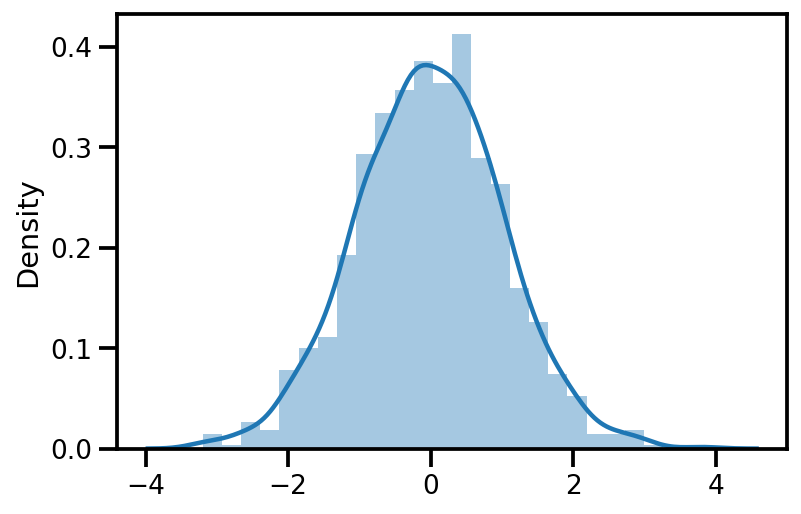

In [19]:
# 乱数の取得：sampleメソッド
samples = normal.sample(1000)
sns.distplot(samples)

Text(0, 0.5, 'y')

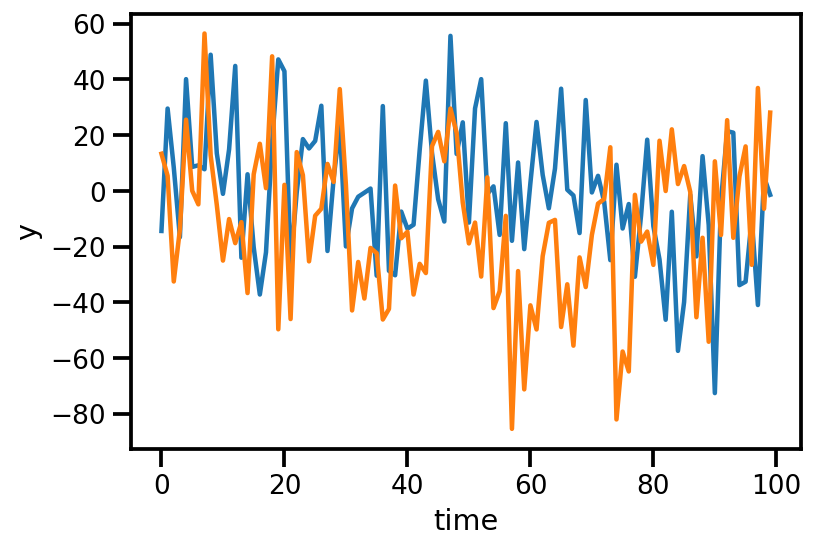

In [20]:
# 線形ガウス状態空間モデル
ndims = 2
step_std = 1.0
noise_std = 5.0

model = tfd.LinearGaussianStateSpaceModel(
  num_timesteps=100,
  transition_matrix=tf.linalg.LinearOperatorIdentity(ndims),
  transition_noise=tfd.MultivariateNormalDiag(
   scale_diag=step_std**2 * tf.ones([ndims])),
  observation_matrix=tf.linalg.LinearOperatorIdentity(ndims),
  observation_noise=tfd.MultivariateNormalDiag(
   scale_diag=noise_std**2 * tf.ones([ndims])),
  initial_state_prior=tfd.MultivariateNormalDiag(
   scale_diag=tf.ones([ndims])))

# １００時点分の2次元の観測値が確率分布（モデル）からの1つのサンプルとなる。
y = model.sample()
for i in range(ndims):
    plt.plot(y[:, i])

plt.xlabel('time')
plt.ylabel('y')

## Bijector

<class 'tensorflow_probability.python.distributions.transformed_distribution.TransformedDistribution'>


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

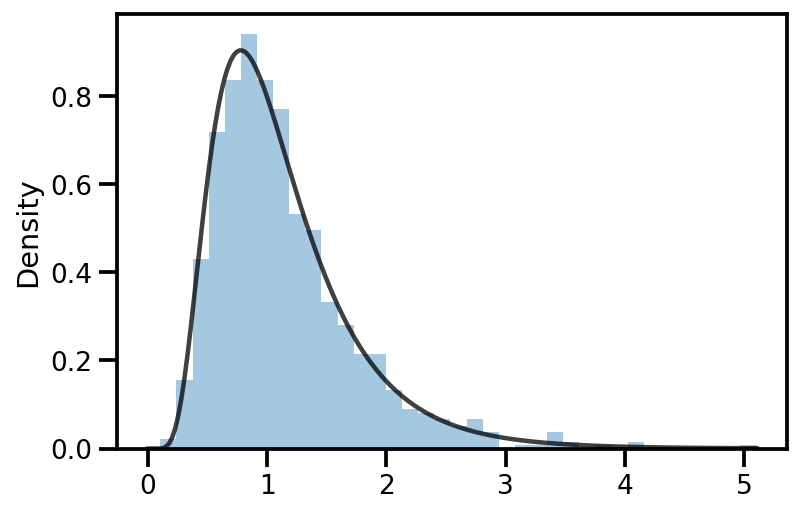

In [21]:
exp_bijector = tfp.bijectors.Exp()
# 変数変換したDistribution
log_normal = exp_bijector(tfd.Normal(0., .5))
print(type(log_normal))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)

plt.ylabel('Density')

## shapeの概念



In [22]:
# パラメータのリストを渡すことで、異なる2つの正規分布をまとめて表現できる
# この場合、batch shapeになる
normal = tfd.Normal(loc=[-1., 1.], scale=[1., 1.5])
print(normal) # Batch: 2, Event: []

# sample shapeは一番左(外側)のaxisに追加される
print('shape of sampled Tensor:', normal.sample(10).shape) # Sample: 10, Batch: 2, Event: []

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32)
shape of sampled Tensor: (10, 2)


In [23]:
# 二変量正規分布
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [24]:
normals = tfd.Normal(loc=[-1., 1.], scale=1.) # scaleはbroadcastされ、[1., 1.]となる
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (2,)
Event shape: ()


In [25]:
print(mvn.sample().shape)
print(normals.sample().shape)

(2,)
(2,)


In [26]:
# Event shape=2の場合、Batch shape=2の場合
print(mvn.log_prob(mvn.sample()))
print(normals.log_prob(normals.sample()))

tf.Tensor(-2.352064, shape=(), dtype=float32)
tf.Tensor([-1.2268479 -1.0877028], shape=(2,), dtype=float32)


In [27]:
normals = tfd.Normal(loc=[-1., 1.], scale=1.) 
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)
print()

normals_ind = tfd.Independent(normals, reinterpreted_batch_ndims=1)
print("Batch shape:", normals_ind.batch_shape)
print("Event shape:", normals_ind.event_shape)

Batch shape: (2,)
Event shape: ()

Batch shape: ()
Event shape: (2,)


In [28]:
# 対数確率を評価してみる。tfd.Independentよりevent　shapeに変換された次元については、対数確率を評価する際にreduce_sumされる。
s = normals.sample()
tf.assert_equal(tf.reduce_sum(normals.log_prob(s)), normals_ind.log_prob(s))

In [29]:
bernoulli = tfd.Bernoulli(probs=0.5)
# 同一の確率分布から複数のサンプルをひとまとめにする
bernoulli_samples = tfd.Sample(bernoulli, sample_shape=10)
print(bernoulli_samples)

tfp.distributions.Sample("SampleBernoulli", batch_shape=[], event_shape=[10], dtype=int32)


In [30]:
s = bernoulli_samples.sample()
print('shape of single sample:', s.shape)

# 複数サンプルについて、対数確率の和が算出される
print(bernoulli_samples.log_prob(s))

shape of single sample: (10,)
tf.Tensor(-6.931472, shape=(), dtype=float32)


# 簡単なモデリングの例

## コイン投げ問題


## JointDistribution

In [31]:
# コインを10回投げ、6回表が出たとする。
N = 10
x = 6

# JointDsitributionを用いて同時分布を定義
Root = tfd.JointDistributionCoroutine.Root
def model():  
    # 事前分布はRootで囲う
    p = yield Root(tfd.Uniform(0, 1))
    x = yield tfd.Binomial(total_count=N, probs=p)

# 同時分布を表すDistributionオブジェクト
binom_model = tfd.JointDistributionCoroutine(model)

# 参考：普通のDistributionと同じように、sampleやlog_probメソッドを利用可能
p_s, x_s = binom_model.sample()
binom_model.log_prob(p_s, x_s)

# 観測データ（表が出た回数）を与え、パラメータを引数として対数事後確率を算出する関数を定義する。
def beta_binom_logp(p):
    return binom_model.log_prob(p, x)


# 参考：JointDistributionを用いない場合、以下のように記述することもできる。
# def beta_binom_logp(p):
#   prior = tfd.Uniform(0, 1)
#   likelihood = tfd.Binomial(total_count=N, probs=p)
#   return prior.log_prob(p) + likelihood.log_prob(x)

## MCMCによる推論

In [32]:
num_results = 6000
num_burnin_steps = 2000

# tf.functionでデコレートすることで、計算グラフがコンパイルされ、高速に実行される
@tf.function(autograph=False, experimental_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      # パラメータの初期値
      current_state=[
          # 複数chainでサンプリングしたい場合、初期値のリストを与える。
          tf.constant([0.5, 0.5, 0.5],  name='init_p')
      ],
      # ハミルトニアン・モンテカルロ法を用いる。step sizeというハイパーパラメータの調整が必要になるが、
      # SimpleStepSizeAdaptationでラップすることで、推論の過程で自動的に調整してくれる。
      # また、今回のパラメータは[0,1]の範囲に制約されているため、TransformedTransitionKernelを利用し、
      # tfb.Sigmoidを適用することで、制約を満たすようにする。
      kernel=tfp.mcmc.SimpleStepSizeAdaptation(
          tfp.mcmc.TransformedTransitionKernel(
            ｔfp.mcmc.HamiltonianMonteCarlo(
              # 先ほど定義した対数事後確率
              target_log_prob_fn=beta_binom_logp,
              step_size=0.1,
              num_leapfrog_steps=5
              ),
          bijector=[tfb.Sigmoid()]),
        num_adaptation_steps=int(num_burnin_steps * 0.8)),
      seed=1)

# statesは事後分布からのサンプル、kernel　resultsには提案が受容されたかどうかなどMCMCの各ステップの情報が含まれる。
states, kernel_results = do_sampling()

# 提案の受容率
acceptance_rates = kernel_results.inner_results.inner_results.is_accepted.numpy().mean(axis=0)
print('Acceptance rate: {0:.1%} {1:.1%} {2:.1%}'.format(*acceptance_rates))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 78.1% 78.2% 76.4%


## 推論結果の確認

In [33]:
#@title utility functioin for TFP
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}
    # from_tfpもあるが、実行するとeager_executionがオフにされてしまうなど現状使いづらいので、from_dictを用いている
    return az.from_dict(trace)

In [34]:
trace = format_trace(states, var_name=['p'], chain_dim=1)
s = az.summary(trace)

display(s)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.583,0.137,0.323,0.828,0.001,0.001,22930.0,4385.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7712cea50>,
      dtype=object)

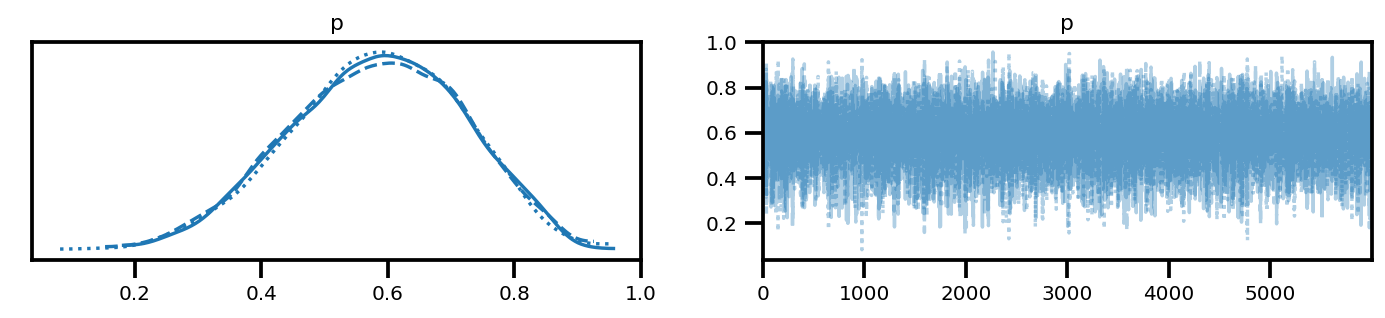

In [35]:
az.plot_trace(trace)

true posterior mean: 0.583


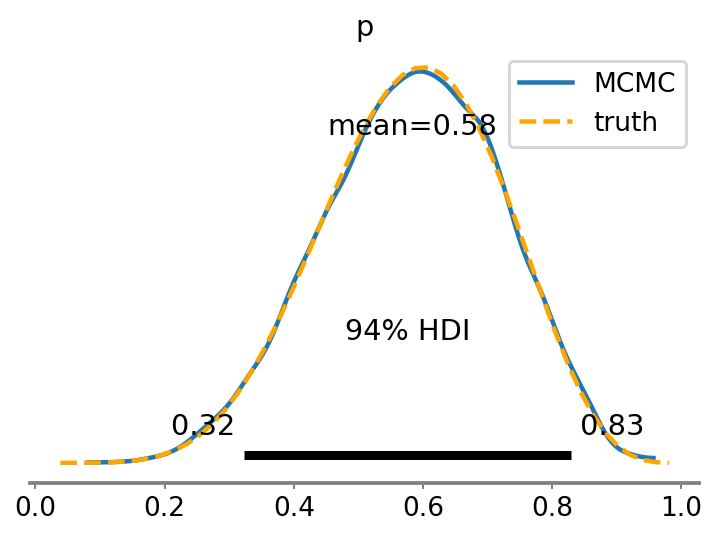

In [36]:
true_posterior = tfd.Beta(1 + x, 1 + N - x)

ax = az.plot_posterior(trace)
ax.lines[0].set_label('MCMC')

xx = np.linspace(*ax.get_xlim())
ax.plot(xx, true_posterior.prob(xx), ls='--', color='orange', label='truth')
ax.legend()

print('true posterior mean: {:.3f}'.format(true_posterior.mean()))

In [37]:
%load_ext watermark
%watermark --iversions

seaborn               : 0.11.2
arviz                 : 0.12.1
matplotlib            : 3.2.2
tensorflow_probability: 0.16.0
tensorflow            : 2.8.0+zzzcolab20220506162203
numpy                 : 1.21.6
sys                   : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
IPython               : 5.5.0

